In [1]:
# import gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Loaded 4811 Expert profiles.
Stratification Levels: 9 Models x 4 Datasets
No cache found. Generating embeddings from scratch...
Loading Model: BAAI/bge-m3...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Saving embeddings to /content/gdrive/MyDrive/expert_embeddings_cache_bge_m3.pkl...
Generation complete and saved.
Performing Stratified Centering...

=== RQ3.1 RESULTS: Framework Distinctiveness ===
Raw Diversity (Polluted by Model Bias):      0.0749
Centered Diversity (Pure Framework Signal):  1.0737
>> CONCLUSION: Frameworks induce distinct identities even after removing Model/Dataset bias.
Running t-SNE on Centered Data...


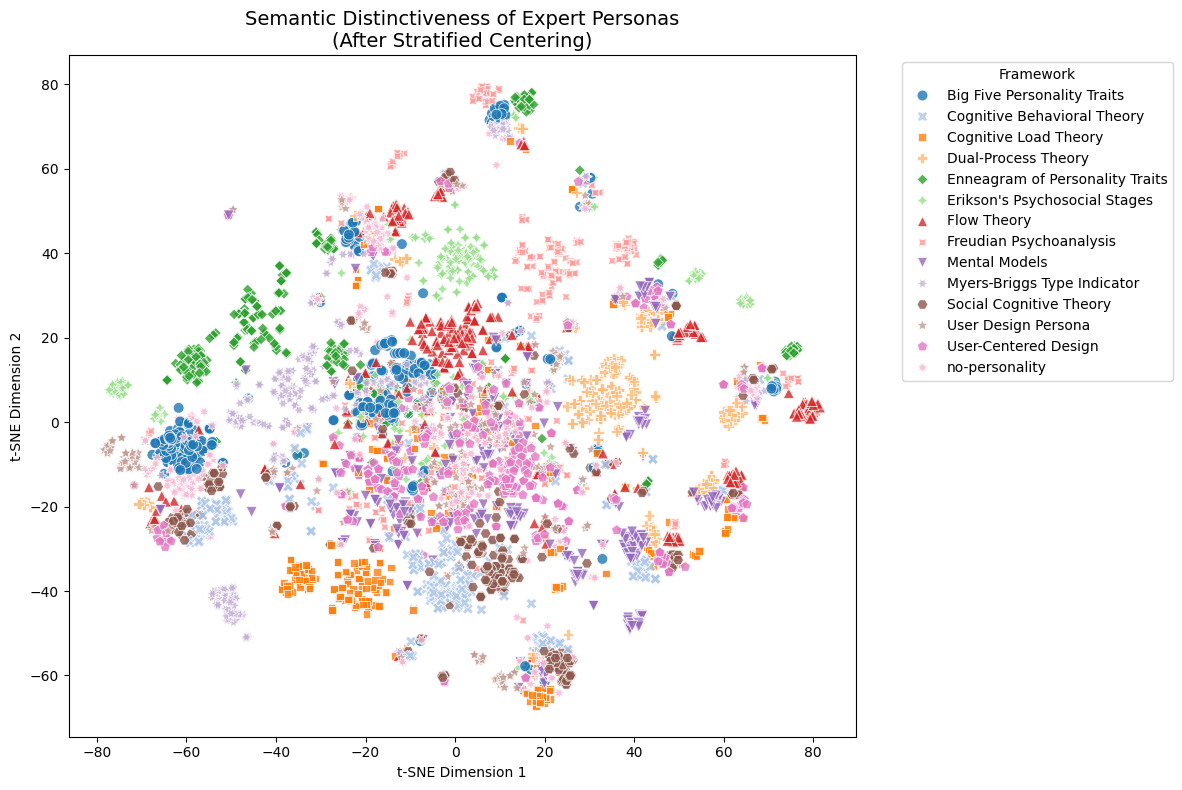

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_distances

# ==========================================
# 1. SETUP & DATA LOADING
# ==========================================
# Load your data
df = pd.read_csv("/content/gdrive/MyDrive/agent_identities.csv")

df["profile_text"] = df["description"]
df["profile_length"] = df["description"].astype(str).apply(len)
df = df[df["profile_length"]>50]
df = df.reset_index(drop=True)

# Filter: We only analyze EXPERTS for Distinctiveness
expert_df = df[df['expert_id'] >= 0].copy()

# Reset index to avoid alignment issues later
expert_df = expert_df.reset_index(drop=True)

print(f"Loaded {len(expert_df)} Expert profiles.")
print(f"Stratification Levels: {expert_df['model'].nunique()} Models x {expert_df['dataset'].nunique()} Datasets")

# ==========================================
# 2. GENERATE OR LOAD EMBEDDINGS
# ==========================================
# Define the path where you want to save/load the data
save_path = "/content/gdrive/MyDrive/expert_embeddings_cache_bge_m3.pkl"

if os.path.exists(save_path):
    print(f"Found cached embeddings at: {save_path}")
    print("Loading data... (This is much faster than regenerating)")
    expert_df = pd.read_pickle(save_path)

    # Re-create the numpy matrix from the loaded dataframe
    matrix_raw = np.stack(expert_df['embedding_raw'].values)
    print("Embeddings loaded successfully.")

else:
    print("No cache found. Generating embeddings from scratch...")

    # Initialize the model
    model_name = 'BAAI/bge-m3'

    print(f"Loading Model: {model_name}...")
    model = SentenceTransformer(model_name, trust_remote_code=True)

    # Generate embeddings
    embeddings_raw = model.encode(expert_df['profile_text'].tolist(), show_progress_bar=True)

    # Store in DataFrame
    expert_df['embedding_raw'] = list(embeddings_raw)

    # Save to Pickle for next time
    print(f"Saving embeddings to {save_path}...")
    expert_df.to_pickle(save_path)

    # Create the matrix for the next steps
    matrix_raw = np.stack(expert_df['embedding_raw'].values)
    print("Generation complete and saved.")

# ==========================================
# 3. STRATIFIED CENTERING
# ==========================================
# Goal: Remove the "Model Bias" and the "Dataset Bias"
# to reveal the "Framework Signal."

print("Performing Stratified Centering...")

# We group by Model AND Dataset.
# This isolates "Llama-3-70b doing CommonsenseQA" as one specific "room."
group_cols = ['model', 'dataset']
grouped = expert_df.groupby(group_cols)

centered_vectors_list = []
indices_list = []

for name, group in grouped:
    # Get the raw embeddings for this specific group
    # We use the index to fetch rows from the main matrix
    group_indices = group.index
    group_matrix = matrix_raw[group_indices]

    # 1. Calculate the "Average Agent" for this Model+Dataset
    local_mean = np.mean(group_matrix, axis=0)

    # 2. Subtract the Mean (Centering)
    # This removes the "Llama-style" and "Medical-topic" noise
    local_centered = group_matrix - local_mean

    # Store results
    centered_vectors_list.append(local_centered)
    indices_list.extend(group_indices)

# Reassemble the sorted pieces back into the original order
# We create a temporary mapping to put them back in the dataframe correctly
flat_centered = np.vstack(centered_vectors_list)
flat_indices = np.array(indices_list)

# Sort back to original index order so it matches the DataFrame
sort_order = np.argsort(flat_indices)
matrix_centered = flat_centered[sort_order]

# Store in DF for safety
expert_df['embedding_centered'] = list(matrix_centered)

# ==========================================
# 4. STATISTICAL PROOF
# ==========================================
# We calculate how distinct the Frameworks are BEFORE and AFTER centering.

def get_framework_distinctiveness(matrix, labels):
    # Convert to DF for easy grouping
    temp = pd.DataFrame(matrix)
    temp['label'] = labels.values

    # Calculate Centroid for each Framework
    centroids = temp.groupby('label').mean().values

    # Calculate cosine distances between all pairs of centroids
    # (Higher distance = More distinct)
    dists = cosine_distances(centroids)

    # Return mean distance (ignoring the diagonal 0s)
    np.fill_diagonal(dists, np.nan)
    return np.nanmean(dists)

score_raw = get_framework_distinctiveness(matrix_raw, expert_df['desc_framework'])
score_centered = get_framework_distinctiveness(matrix_centered, expert_df['desc_framework'])

print("\n=== RQ3.1 RESULTS: Framework Distinctiveness ===")
print(f"Raw Diversity (Polluted by Model Bias):      {score_raw:.4f}")
print(f"Centered Diversity (Pure Framework Signal):  {score_centered:.4f}")

if score_centered > 0.05: # Threshold depends on model, but >0 is the requirement
    print(">> CONCLUSION: Frameworks induce distinct identities even after removing Model/Dataset bias.")
else:
    print(">> CONCLUSION: Mode Collapse. Frameworks are not distinct.")

# ==========================================
# 5. VISUALIZATION (t-SNE)
# ==========================================
# We visualize the CENTERED data to show the distinct clusters in the Thesis.

print("Running t-SNE on Centered Data...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
vis_dims = tsne.fit_transform(matrix_centered)

expert_df['x'] = vis_dims[:, 0]
expert_df['y'] = vis_dims[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=expert_df,
    x='x', y='y',
    hue='desc_framework',
    style='desc_framework', # Helps distinguish points if colors are similar
    palette='tab20',        # High contrast palette
    s=60, alpha=0.8
)
plt.title('Semantic Distinctiveness of Expert Personas\n(After Stratified Centering)', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Framework')
plt.tight_layout()
plt.show()

Running t-SNE on Centered Data...


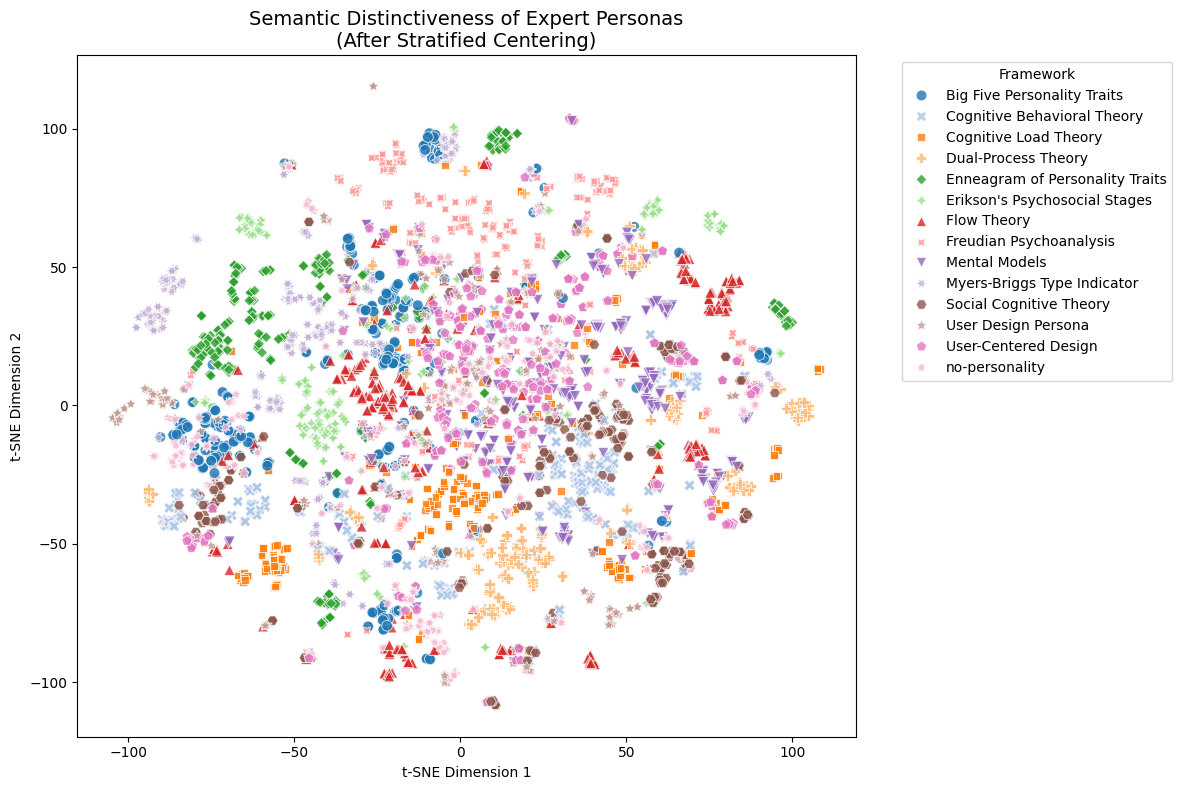

In [ ]:
# ==========================================
# 5. VISUALIZATION (t-SNE)
# ==========================================
# We visualize the CENTERED data to show the distinct clusters in the Thesis.

print("Running t-SNE on Centered Data...")
tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='pca', learning_rate='auto')
vis_dims = tsne.fit_transform(matrix_centered)

expert_df['x'] = vis_dims[:, 0]
expert_df['y'] = vis_dims[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=expert_df,
    x='x', y='y',
    hue='desc_framework',
    style='desc_framework', # Helps distinguish points if colors are similar
    palette='tab20',        # High contrast palette
    s=60, alpha=0.8
)
plt.title('Semantic Distinctiveness of Expert Personas\n(After Stratified Centering)', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Framework')
plt.tight_layout()
plt.show()

Running t-SNE on Centered Data...


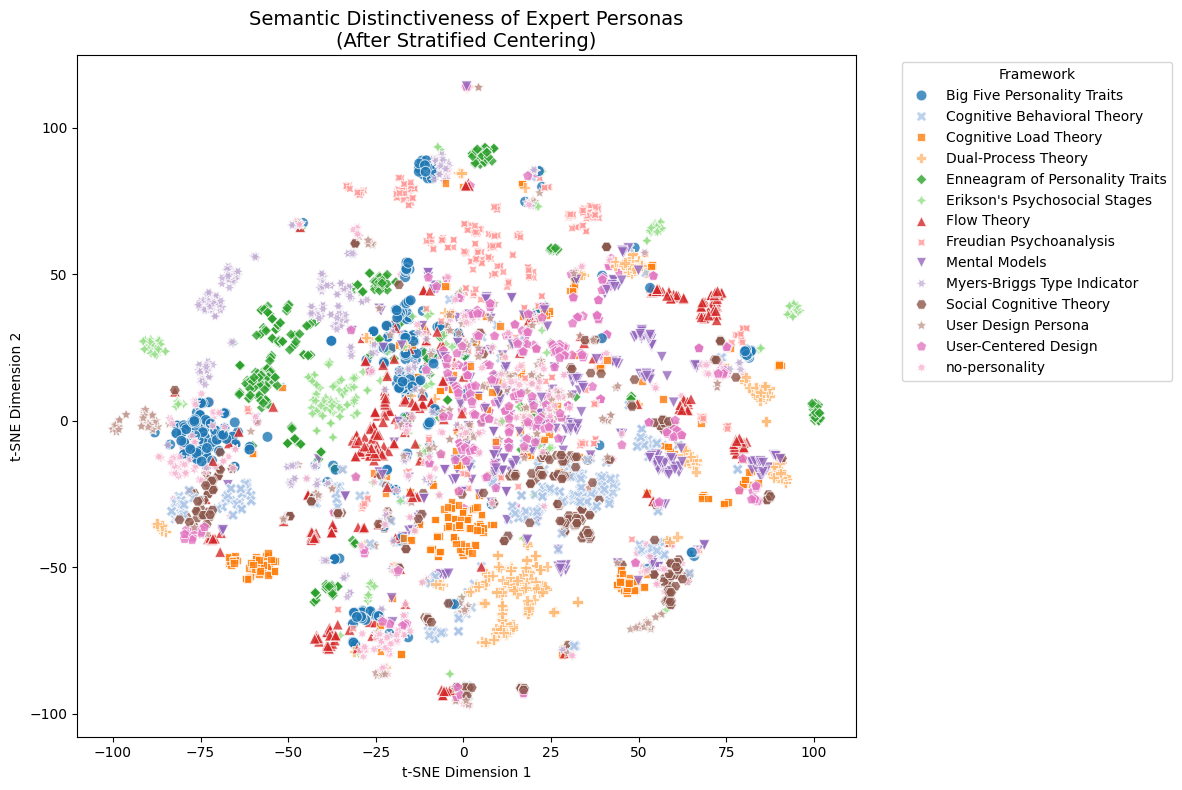

In [ ]:
# ==========================================
# 5. VISUALIZATION (t-SNE)
# ==========================================
# We visualize the CENTERED data to show the distinct clusters in the Thesis.

print("Running t-SNE on Centered Data...")
tsne = TSNE(n_components=2, perplexity=10, random_state=42, init='pca', learning_rate='auto')
vis_dims = tsne.fit_transform(matrix_centered)

expert_df['x'] = vis_dims[:, 0]
expert_df['y'] = vis_dims[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=expert_df,
    x='x', y='y',
    hue='desc_framework',
    style='desc_framework', # Helps distinguish points if colors are similar
    palette='tab20',        # High contrast palette
    s=60, alpha=0.8
)
plt.title('Semantic Distinctiveness of Expert Personas\n(After Stratified Centering)', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Framework')
plt.tight_layout()
plt.show()

Running t-SNE on Centered Data...


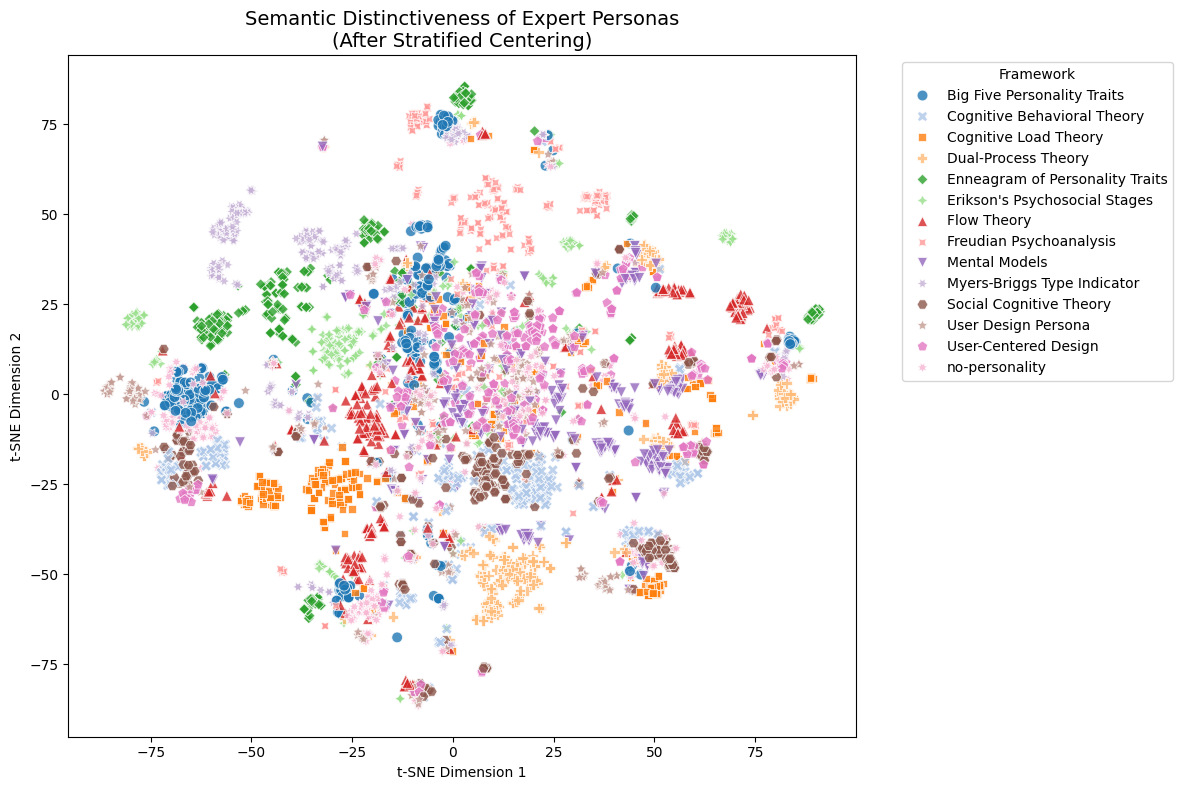

In [ ]:
# ==========================================
# 5. VISUALIZATION (t-SNE)
# ==========================================
# We visualize the CENTERED data to show the distinct clusters in the Thesis.

print("Running t-SNE on Centered Data...")
tsne = TSNE(n_components=2, perplexity=20, random_state=42, init='pca', learning_rate='auto')
vis_dims = tsne.fit_transform(matrix_centered)

expert_df['x'] = vis_dims[:, 0]
expert_df['y'] = vis_dims[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=expert_df,
    x='x', y='y',
    hue='desc_framework',
    style='desc_framework', # Helps distinguish points if colors are similar
    palette='tab20',        # High contrast palette
    s=60, alpha=0.8
)
plt.title('Semantic Distinctiveness of Expert Personas\n(After Stratified Centering)', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Framework')
plt.tight_layout()
plt.show()

Running t-SNE on Centered Data...


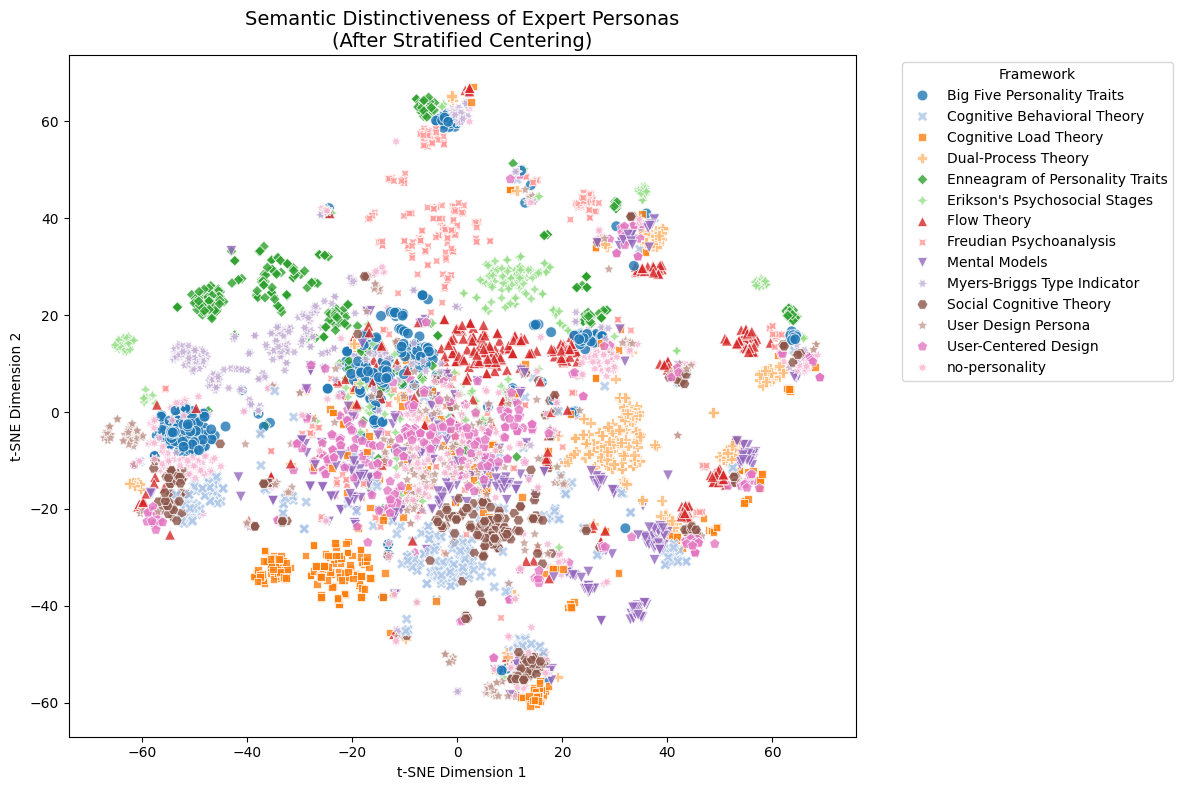

In [ ]:
# ==========================================
# 5. VISUALIZATION (t-SNE)
# ==========================================
# We visualize the CENTERED data to show the distinct clusters in the Thesis.

print("Running t-SNE on Centered Data...")
tsne = TSNE(n_components=2, perplexity=50, random_state=42, init='pca', learning_rate='auto')
vis_dims = tsne.fit_transform(matrix_centered)

expert_df['x'] = vis_dims[:, 0]
expert_df['y'] = vis_dims[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=expert_df,
    x='x', y='y',
    hue='desc_framework',
    style='desc_framework', # Helps distinguish points if colors are similar
    palette='tab20',        # High contrast palette
    s=60, alpha=0.8
)
plt.title('Semantic Distinctiveness of Expert Personas\n(After Stratified Centering)', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Framework')
plt.tight_layout()
plt.show()

In [2]:
!pip install transformers==4.51.0 sentence-transformers==3.4.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.9/275.9 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 89.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.4.0
    Uninstalling huggingface_hub-1.4.0:
      Successfully uninstalled huggingface_hub-1.4.0
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.2
    Uninstalling tokenizers-0.22.2:
      Successfully uninstalled tokenizers-0.22.2
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 5.2.2
    Uninstalling sentence-transformers-

Loaded 4811 Expert profiles.
Stratification Levels: 9 Models x 4 Datasets
No cache found. Generating embeddings from scratch...
Loading Model: jinaai/jina-embeddings-v2-base-en...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_bert.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_bert.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- modeling_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/275M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Saving embeddings to /content/gdrive/MyDrive/expert_embeddings_cache_jina.pkl...
Generation complete and saved.
Performing Stratified Centering...

=== RQ3.1 RESULTS: Framework Distinctiveness ===
Raw Diversity (Polluted by Model Bias):      0.0262
Centered Diversity (Pure Framework Signal):  1.0745
>> CONCLUSION: Frameworks induce distinct identities even after removing Model/Dataset bias.
Running t-SNE on Centered Data...


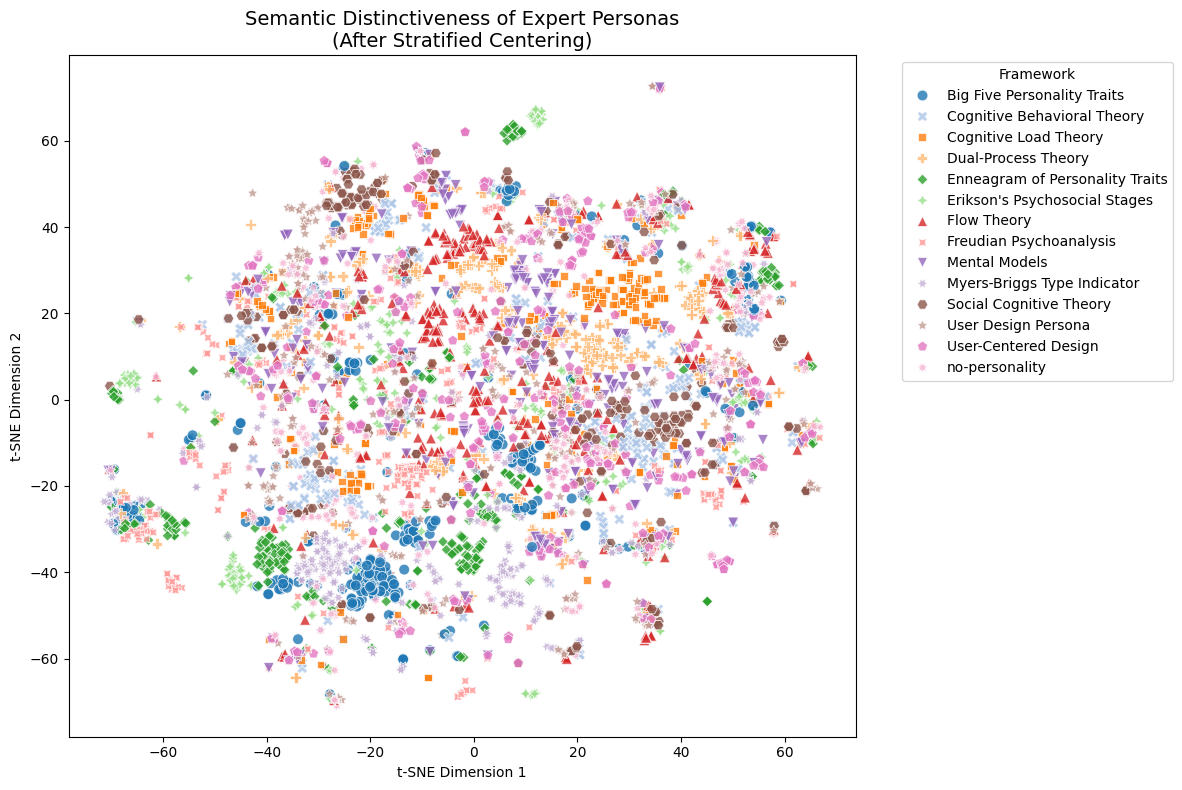

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_distances

# ==========================================
# 1. SETUP & DATA LOADING
# ==========================================
# Load your data
df = pd.read_csv("/content/gdrive/MyDrive/agent_identities.csv")

df["profile_text"] = df["description"]
df["profile_length"] = df["description"].astype(str).apply(len)
df = df[df["profile_length"]>50]
df = df.reset_index(drop=True)

# Filter: We only analyze EXPERTS for Distinctiveness
expert_df = df[df['expert_id'] >= 0].copy()

# Reset index to avoid alignment issues later
expert_df = expert_df.reset_index(drop=True)

print(f"Loaded {len(expert_df)} Expert profiles.")
print(f"Stratification Levels: {expert_df['model'].nunique()} Models x {expert_df['dataset'].nunique()} Datasets")

# ==========================================
# 2. GENERATE OR LOAD EMBEDDINGS
# ==========================================
# Define the path where you want to save/load the data
save_path = "/content/gdrive/MyDrive/expert_embeddings_cache_jina.pkl"

if os.path.exists(save_path):
    print(f"Found cached embeddings at: {save_path}")
    print("Loading data... (This is much faster than regenerating)")
    expert_df = pd.read_pickle(save_path)

    # Re-create the numpy matrix from the loaded dataframe
    matrix_raw = np.stack(expert_df['embedding_raw'].values)
    print("Embeddings loaded successfully.")

else:
    print("No cache found. Generating embeddings from scratch...")

    # Initialize the model
    model_name = 'jinaai/jina-embeddings-v2-base-en'
    print(f"Loading Model: {model_name}...")
    model = SentenceTransformer(model_name, trust_remote_code=True)

    # Generate embeddings
    embeddings_raw = model.encode(expert_df['profile_text'].tolist(), show_progress_bar=True)

    # Store in DataFrame
    expert_df['embedding_raw'] = list(embeddings_raw)

    # Save to Pickle for next time
    print(f"Saving embeddings to {save_path}...")
    expert_df.to_pickle(save_path)

    # Create the matrix for the next steps
    matrix_raw = np.stack(expert_df['embedding_raw'].values)
    print("Generation complete and saved.")

# ==========================================
# 3. STRATIFIED CENTERING
# ==========================================
# Goal: Remove the "Model Bias" and the "Dataset Bias"
# to reveal the "Framework Signal."

print("Performing Stratified Centering...")

# We group by Model AND Dataset.
# This isolates "Llama-3-70b doing CommonsenseQA" as one specific "room."
group_cols = ['model', 'dataset']
grouped = expert_df.groupby(group_cols)

centered_vectors_list = []
indices_list = []

for name, group in grouped:
    # Get the raw embeddings for this specific group
    # We use the index to fetch rows from the main matrix
    group_indices = group.index
    group_matrix = matrix_raw[group_indices]

    # 1. Calculate the "Average Agent" for this Model+Dataset
    local_mean = np.mean(group_matrix, axis=0)

    # 2. Subtract the Mean (Centering)
    # This removes the "Llama-style" and "Medical-topic" noise
    local_centered = group_matrix - local_mean

    # Store results
    centered_vectors_list.append(local_centered)
    indices_list.extend(group_indices)

# Reassemble the sorted pieces back into the original order
# We create a temporary mapping to put them back in the dataframe correctly
flat_centered = np.vstack(centered_vectors_list)
flat_indices = np.array(indices_list)

# Sort back to original index order so it matches the DataFrame
sort_order = np.argsort(flat_indices)
matrix_centered = flat_centered[sort_order]

# Store in DF for safety
expert_df['embedding_centered'] = list(matrix_centered)

# ==========================================
# 4. STATISTICAL PROOF
# ==========================================
# We calculate how distinct the Frameworks are BEFORE and AFTER centering.

def get_framework_distinctiveness(matrix, labels):
    # Convert to DF for easy grouping
    temp = pd.DataFrame(matrix)
    temp['label'] = labels.values

    # Calculate Centroid for each Framework
    centroids = temp.groupby('label').mean().values

    # Calculate cosine distances between all pairs of centroids
    # (Higher distance = More distinct)
    dists = cosine_distances(centroids)

    # Return mean distance (ignoring the diagonal 0s)
    np.fill_diagonal(dists, np.nan)
    return np.nanmean(dists)

score_raw = get_framework_distinctiveness(matrix_raw, expert_df['desc_framework'])
score_centered = get_framework_distinctiveness(matrix_centered, expert_df['desc_framework'])

print("\n=== RQ3.1 RESULTS: Framework Distinctiveness ===")
print(f"Raw Diversity (Polluted by Model Bias):      {score_raw:.4f}")
print(f"Centered Diversity (Pure Framework Signal):  {score_centered:.4f}")

if score_centered > 0.05: # Threshold depends on model, but >0 is the requirement
    print(">> CONCLUSION: Frameworks induce distinct identities even after removing Model/Dataset bias.")
else:
    print(">> CONCLUSION: Mode Collapse. Frameworks are not distinct.")

# ==========================================
# 5. VISUALIZATION (t-SNE)
# ==========================================
# We visualize the CENTERED data to show the distinct clusters in the Thesis.

print("Running t-SNE on Centered Data...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
vis_dims = tsne.fit_transform(matrix_centered)

expert_df['x'] = vis_dims[:, 0]
expert_df['y'] = vis_dims[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=expert_df,
    x='x', y='y',
    hue='desc_framework',
    style='desc_framework', # Helps distinguish points if colors are similar
    palette='tab20',        # High contrast palette
    s=60, alpha=0.8
)
plt.title('Semantic Distinctiveness of Expert Personas\n(After Stratified Centering)', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Framework')
plt.tight_layout()
plt.show()

Running t-SNE on Centered Data...


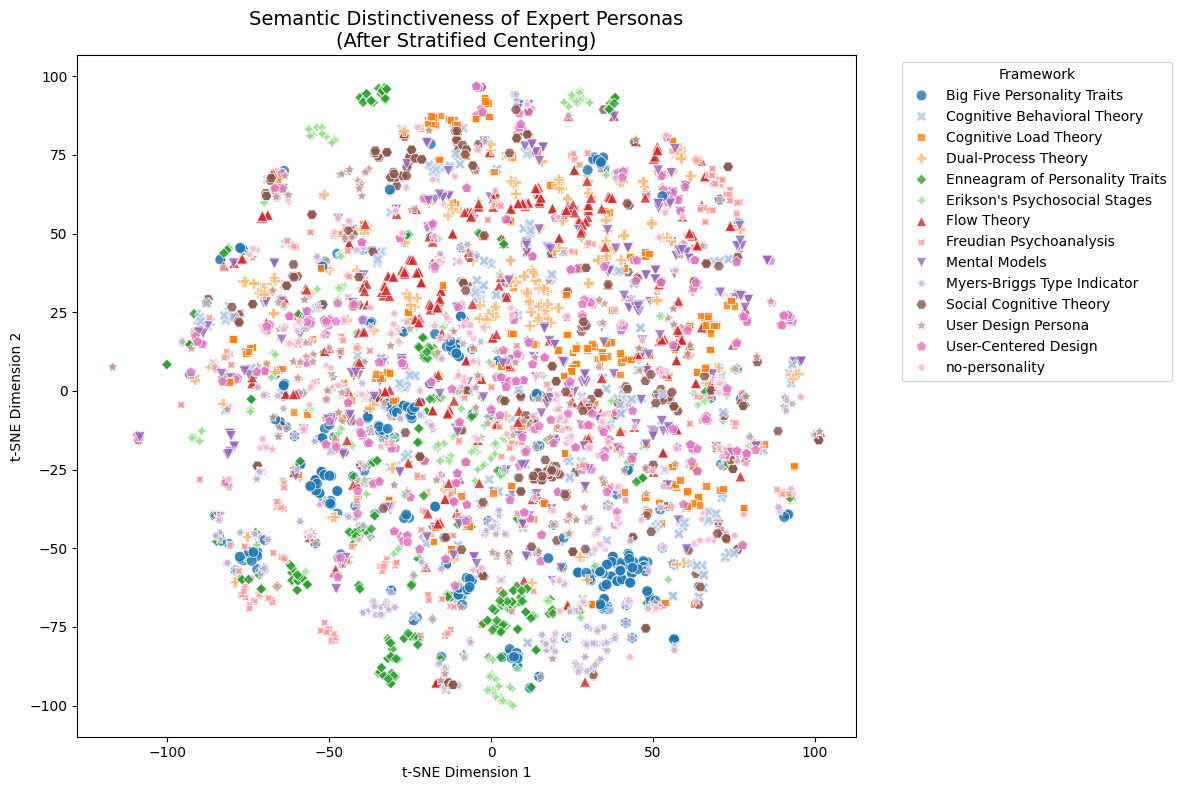

In [4]:
# ==========================================
# 5. VISUALIZATION (t-SNE)
# ==========================================
# We visualize the CENTERED data to show the distinct clusters in the Thesis.

print("Running t-SNE on Centered Data...")
tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='pca', learning_rate='auto')
vis_dims = tsne.fit_transform(matrix_centered)

expert_df['x'] = vis_dims[:, 0]
expert_df['y'] = vis_dims[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=expert_df,
    x='x', y='y',
    hue='desc_framework',
    style='desc_framework', # Helps distinguish points if colors are similar
    palette='tab20',        # High contrast palette
    s=60, alpha=0.8
)
plt.title('Semantic Distinctiveness of Expert Personas\n(After Stratified Centering)', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Framework')
plt.tight_layout()
plt.show()

Running t-SNE on Centered Data...


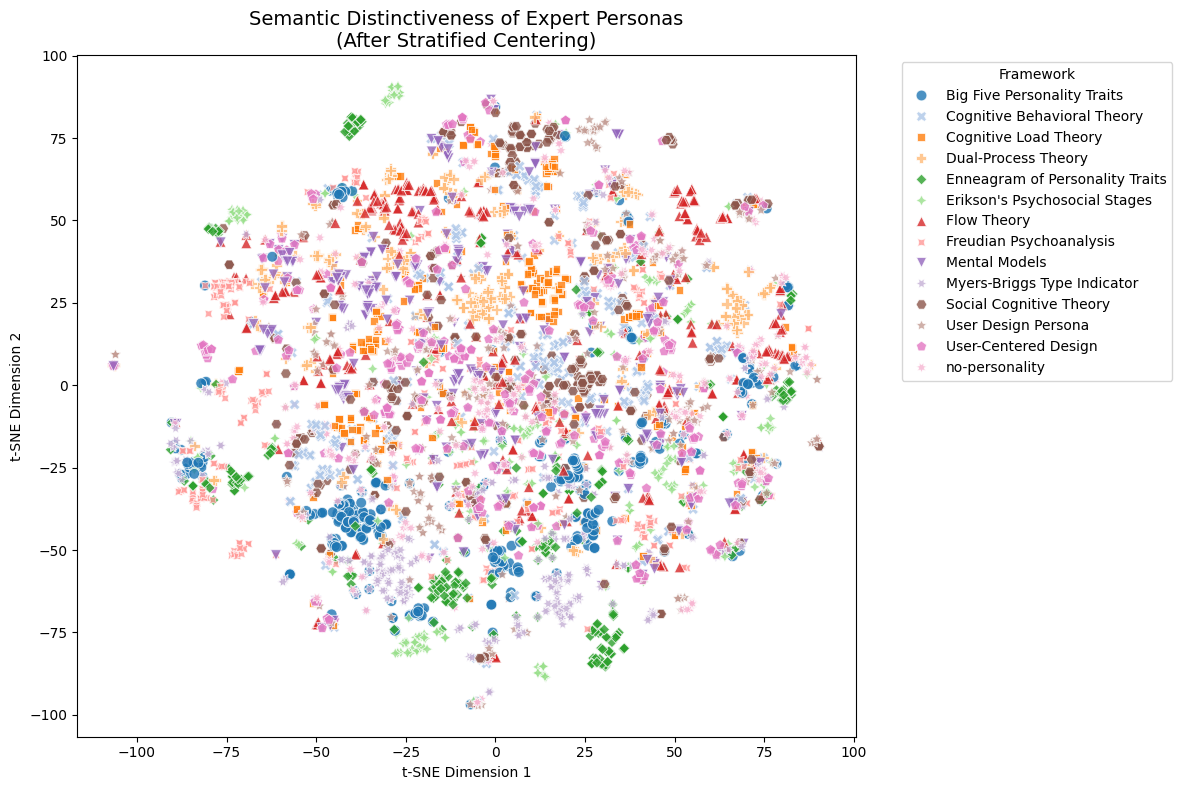

In [5]:
# ==========================================
# 5. VISUALIZATION (t-SNE)
# ==========================================
# We visualize the CENTERED data to show the distinct clusters in the Thesis.

print("Running t-SNE on Centered Data...")
tsne = TSNE(n_components=2, perplexity=10, random_state=42, init='pca', learning_rate='auto')
vis_dims = tsne.fit_transform(matrix_centered)

expert_df['x'] = vis_dims[:, 0]
expert_df['y'] = vis_dims[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=expert_df,
    x='x', y='y',
    hue='desc_framework',
    style='desc_framework', # Helps distinguish points if colors are similar
    palette='tab20',        # High contrast palette
    s=60, alpha=0.8
)
plt.title('Semantic Distinctiveness of Expert Personas\n(After Stratified Centering)', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Framework')
plt.tight_layout()
plt.show()

Running t-SNE on Centered Data...


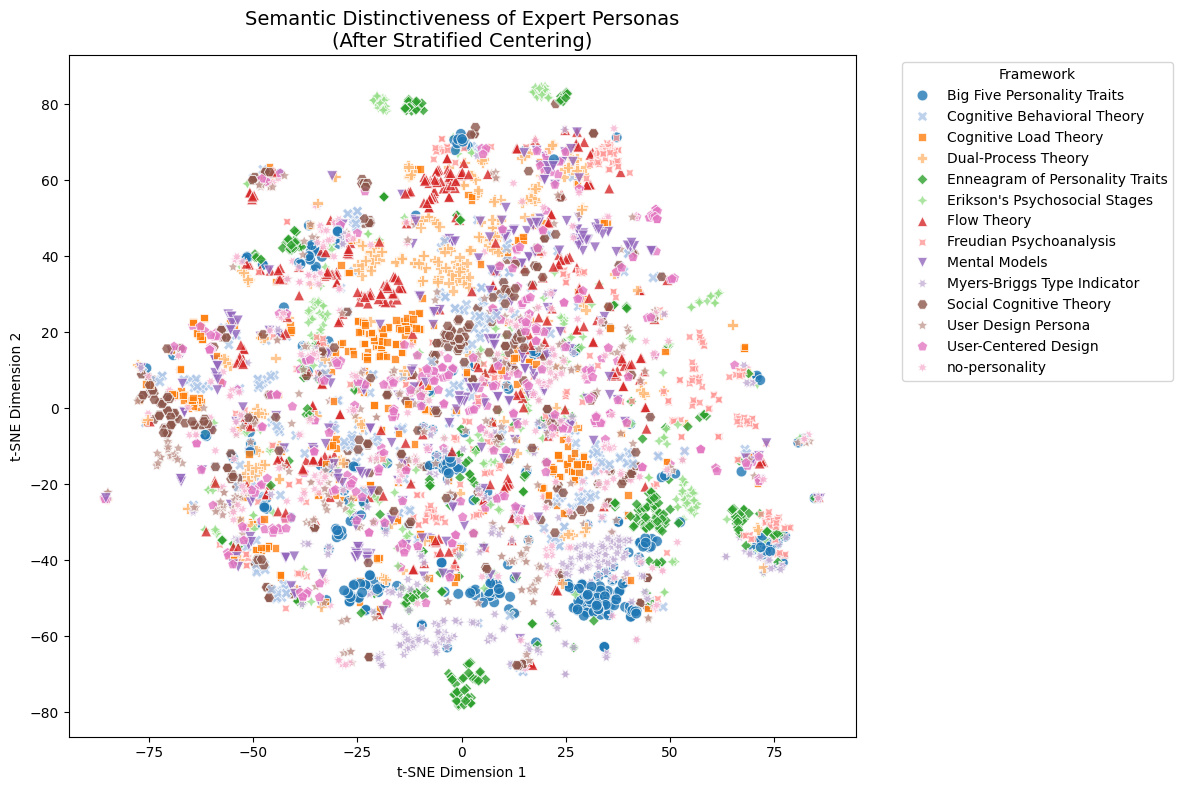

In [6]:
# ==========================================
# 5. VISUALIZATION (t-SNE)
# ==========================================
# We visualize the CENTERED data to show the distinct clusters in the Thesis.

print("Running t-SNE on Centered Data...")
tsne = TSNE(n_components=2, perplexity=20, random_state=42, init='pca', learning_rate='auto')
vis_dims = tsne.fit_transform(matrix_centered)

expert_df['x'] = vis_dims[:, 0]
expert_df['y'] = vis_dims[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=expert_df,
    x='x', y='y',
    hue='desc_framework',
    style='desc_framework', # Helps distinguish points if colors are similar
    palette='tab20',        # High contrast palette
    s=60, alpha=0.8
)
plt.title('Semantic Distinctiveness of Expert Personas\n(After Stratified Centering)', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Framework')
plt.tight_layout()
plt.show()

Running t-SNE on Centered Data...


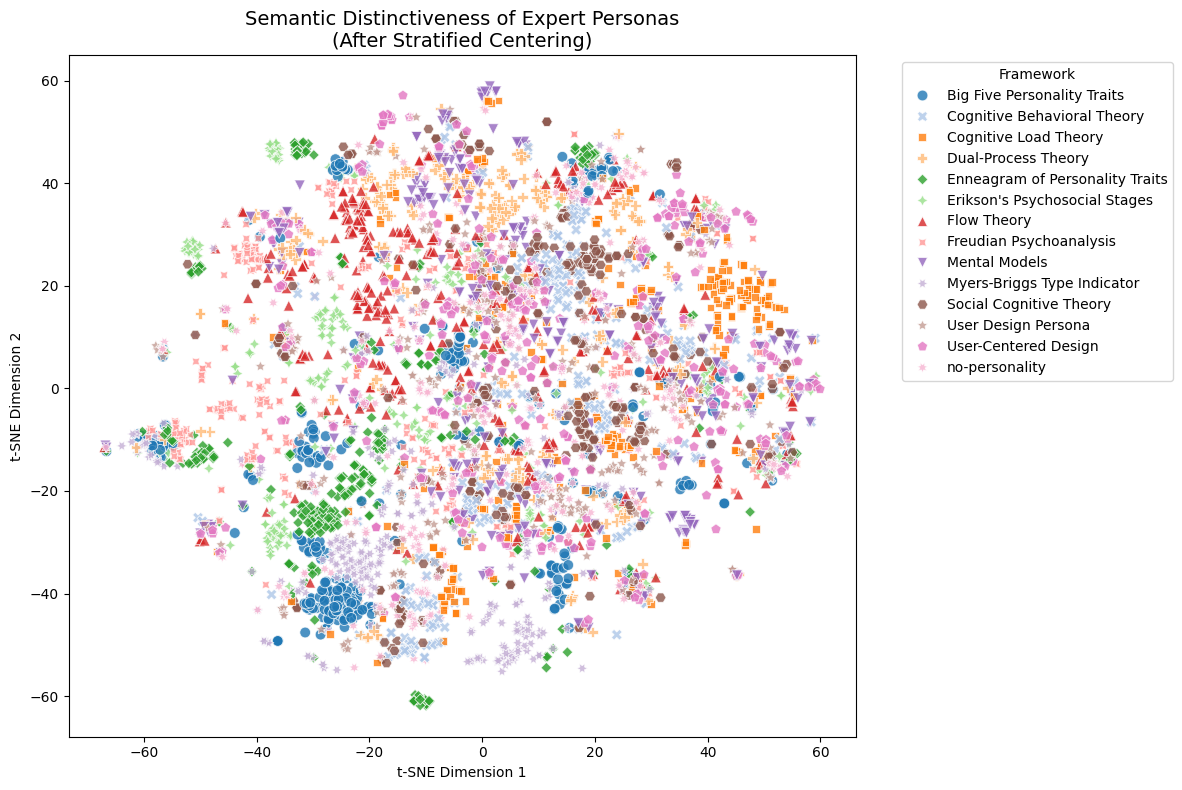

In [7]:
# ==========================================
# 5. VISUALIZATION (t-SNE)
# ==========================================
# We visualize the CENTERED data to show the distinct clusters in the Thesis.

print("Running t-SNE on Centered Data...")
tsne = TSNE(n_components=2, perplexity=50, random_state=42, init='pca', learning_rate='auto')
vis_dims = tsne.fit_transform(matrix_centered)

expert_df['x'] = vis_dims[:, 0]
expert_df['y'] = vis_dims[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=expert_df,
    x='x', y='y',
    hue='desc_framework',
    style='desc_framework', # Helps distinguish points if colors are similar
    palette='tab20',        # High contrast palette
    s=60, alpha=0.8
)
plt.title('Semantic Distinctiveness of Expert Personas\n(After Stratified Centering)', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Framework')
plt.tight_layout()
plt.show()